# ITU-T P.1203 Model Fine-Tuning

Based on our subjective testing data

# Notes

**07.11**
So I believe the bitrate values are all wrong here
Firstly, Minh also appears to have used mbps in the p1203 calculation, which is wrong (or maybe was right at the time of the previous fine-tuning)
Now the p1203 model clearly uses kbits/second

I am collecting all video bitrates in bytes and then converting them to mbits/second, before multiplying them by 1000 to get kbits/second
I am also only storing the bitrate in kbits to avoid confusion

The way to get the megabits values is:
1. get the size of the bin file in bytes (or kilobytes)
2. convert it to megabits by dividing by 125000
3. divide it by 10 (since the bin file is for 10-seconds) to get megabits / second
4. multiply it by 1000 to get kbit/s
All of our sequences are 10-second sequences, thus we divide by 10

The video bitrates are as follows:
```
BlueSpin-r1.bin: 14000.33 kilobits
BlueSpin-r2.bin: 18358.77 kilobits
BlueSpin-r3.bin: 25381.74 kilobits
BlueSpin-r4.bin: 60218.56 kilobits
BlueSpin-r5.bin: 100957.13 kilobits
CasualSquat-r1.bin: 20028.41 kilobits
CasualSquat-r2.bin: 31350.91 kilobits
CasualSquat-r3.bin: 53280.41 kilobits
CasualSquat-r4.bin: 156102.30 kilobits
CasualSquat-r5.bin: 248934.89 kilobits
FlowerDance-r1.bin: 21305.45 kilobits
FlowerDance-r2.bin: 33934.77 kilobits
FlowerDance-r3.bin: 57028.55 kilobits
FlowerDance-r4.bin: 182492.95 kilobits
FlowerDance-r5.bin: 314833.07 kilobits
longdress-r1.bin: 45330.51 kilobits
longdress-r3.bin: 137209.71 kilobits
longdress-r5.bin: 456825.40 kilobits
loot-r1.bin: 22223.74 kilobits
loot-r3.bin: 54941.94 kilobits
loot-r5.bin: 162842.81 kilobits
ReadyForWinter-r1.bin: 15823.20 kilobits
ReadyForWinter-r2.bin: 20687.30 kilobits
ReadyForWinter-r3.bin: 28919.76 kilobits
ReadyForWinter-r4.bin: 74742.73 kilobits
ReadyForWinter-r5.bin: 132748.28 kilobits
redandblack-r1.bin: 33068.13 kilobits
redandblack-r3.bin: 73753.55 kilobits
redandblack-r5.bin: 223673.06 kilobits
soldier-r1.bin: 42745.16 kilobits
soldier-r3.bin: 113102.48 kilobits
soldier-r5.bin: 344626.97 kilobits
```

# Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from itu_p1203 import P1203Standalone
from itertools import permutations
import json
import numpy as np
from datetime import datetime
from scipy.optimize import brute, shgo, dual_annealing
from enum import Enum

/home/shivi/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Universal Data

In [2]:
# Filepaths to Mode 0 template JSON files
oldtests_mode0_json_filepath = "./mode0-oldtests.json"
newtests_mode0_json_filepath = "./mode0-newtests.json"
bothtests_mode0_json_filepath = "./mode0-bothtests.json"

# User QoE Scores CSV File
qoe_csv_filepath = "./results/test_scores.csv"

# Bitrate and resolution information for all the videos in KBPS

# New aka ComPEQ-MR Dataset
bitrates_kbps_new = {
    "BlueSpin": {
        "r01": 14000.33,
        "r02": 18358.77,
        "r03": 25381.74,
        "r04": 60218.56,
        "r05": 100957.13,
    },
    "CasualSquat": {
        "r01": 20028.41,
        "r02": 31350.91,
        "r03": 53280.41,
        "r04": 156102.30,
        "r05": 248934.89,
    },
    "ReadyForWinter": {
        "r01": 15823.20,
        "r02": 20687.30,
        "r03": 28919.76,
        "r04": 74742.73,
        "r05": 132748.28,
    },
    "FlowerDance": {
        "r01": 21305.45,
        "r02": 33934.77,
        "r03": 57028.55,
        "r04": 182492.95,
        "r05": 314833.07,
    },
}

resolution_map_new = {
    "r01": "640x360",  # worse than 420p
    "r02": "852x480",  # exactly 480p
    "r03": "1192x672",  # bit worse than 720p
    "r04": "1533x864",  # a bit better than 720p
    "r05": "1920x1080",  # exactly 1080p
}

distance_map_new = {"d200": "200cm"}

# Old dataset from first round of subjective testing
bitrates_kbps_old = {
    "LongDress": {"r1": 45330.51, "r3": 137209.71, "r5": 456825.40},
    "Loot": {"r1": 22223.74, "r3": 54941.94, "r5": 162842.81},
    "RedAndBlack": {"r1": 33068.13, "r3": 73753.55, "r5": 223673.06},
    "Soldier": {"r1": 42745.16, "r3": 113102.48, "r5": 344626.97},
}

resolution_map_old = {
    "r1": "854x480",  # old dataset 480p
    "r3": "1280x720",  # old dataset 720p
    "r5": "1920x1080",  # old dataset 1080p
}

distance_map_old = {"d125": "125cm", "d250": "250cm", "d500": "500cm"}

# Default P1203 coefficients
_COEFFS = {
    "u1": 72.61,
    "u2": 0.32,
    "t1": 30.98,
    "t2": 1.29,
    "t3": 64.65,
    "q1": 4.66,
    "q2": -0.07,
    "q3": 4.06,
    "mode0": {
        "a1": 11.9983519,
        "a2": -2.99991847,
        "a3": 41.2475074001,
        "a4": 0.13183165961,
    },
    "mode1": {
        "a1": 5.00011566,
        "a2": -1.19630824,
        "a3": 41.3585049,
        "a4": 0,
        "c0": -0.91562479,
        "c1": 0,
        "c2": -3.28579526,
        "c3": 20.4098663,
    },
    "htv_1": -0.60293,
    "htv_2": 2.12382,
    "htv_3": -0.36936,
    "htv_4": 0.03409,
}

## Controlling the Program

In [3]:
# Global Flags
old_tests = False
new_tests = True

# Set the training and the validation point cloud object names

if old_tests and new_tests:
    training_object_names = ["BlueSpin", "CasualSquat", "LongDress", "Loot"]
    validation_object_names = [
        "ReadyForWinter",
        "FlowerDance",
        "RedAndBlack",
        "Soldier",
    ]
elif old_tests:
    training_object_names = ["LongDress", "Loot"]
    validation_object_names = ["RedAndBlack", "Soldier"]
else:
    training_object_names = ["BlueSpin", "CasualSquat"]
    validation_object_names = ["ReadyForWinter", "FlowerDance"]

# Load the Input Json
if old_tests and new_tests:
    f = open(bothtests_mode0_json_filepath)
elif old_tests:
    f = open(oldtests_mode0_json_filepath)
else:
    f = open(newtests_mode0_json_filepath)

input_json = json.load(f)

# Set the suffix for the savefile names
if old_tests and new_tests:
    graph_savename_suffix = "_BOTH"
elif old_tests:
    graph_savename_suffix = "_OLD"
else:
    graph_savename_suffix = "_NEW"

# Optimization Methods
# optimization_methods = ['basinhopping', 'brute', 'differential_evolution', 'shgo', 'dual_annealing', 'direct']
optimization_methods = [
    "dual_annealing",
    "shgo",
    "brute",
]  # only using these three methods for now

current_optimization_method = (
    None  # if this is none then we go through all the ones above!
)
# current_optimization_method = 'dual_annealing'

# bounds = [(-5,30), (-10, 10), (-10, 160), (-10, 10)]
bounds = [(1, 15), (-5, 5), (0, 80), (0, 5)]


# Training or validation
class DatasetType(Enum):
    TRAINING = (1,)
    VALIDATION = 2


# groupby column names
groupby_columns = ["object", "start_qual", "end_qual", "dist"]

# Utility Functions

In [4]:
# Split the object string into object, start_qual, end_qual, and distance
def split_object_column(object_string):
    if (
        "BlueSpin" in object_string
        or "FlowerDance" in object_string
        or "ReadyForWinter" in object_string
        or "CasualSquat" in object_string
    ):
        split_string = object_string.split("_")
        split_string[1] = split_string[2]
        return split_string
    elif (
        "LongDress" in object_string
        or "Loot" in object_string
        or "Soldier" in object_string
        or "RedAndBlack" in object_string
    ):
        return object_string.split("_")

In [5]:
# Remove outliers using the boxplot method
def boxplot_outlier_filter(frame):
    """
    Outlier filter using interquantile range (filter below Q1 - 1.5 IQR and above Q3 + 1.5 IQR)

    :param frame: data frame
    :return: filtered frame
    """
    q1 = frame.quantile(0.25, numeric_only=True)["rate"]
    q3 = frame.quantile(0.75, numeric_only=True)["rate"]

    # interquantile range
    iqr = q3 - q1
    fence_low = q1 - (1.5 * iqr)
    fence_high = q3 + (1.5 * iqr)

    # filter the frame
    filtered = (frame["rate"] >= fence_low) & (frame["rate"] <= fence_high)
    return frame.loc[filtered]

In [6]:
# Calculate RMSE between Groundtruth and P1203 QoE data
def calculate_rmse(ground_truth, p1203_results):
    p1203_results = p1203_results[
        ["object", "start_qual", "end_qual", "dist", "p1203_qoe"]
    ]
    ground_truth = ground_truth[["object", "start_qual", "end_qual", "dist", "rate"]]
    joined_qoe_results = p1203_results.merge(ground_truth)
    rmse_arr = []
    for idx in np.arange(joined_qoe_results.shape[0]):
        # Get all the ratings for this object and qualities by the user
        targets = joined_qoe_results.iloc[idx, :]["rate"]

        # Get the P1203 rating for this object and quality and span it across all user ratings
        predictions = np.full(
            len(targets),
            joined_qoe_results.loc[joined_qoe_results.index[idx], "p1203_qoe"],
        )

        # get the RMSE between the p1203 and the user ratings
        rmse_arr.append(np.sqrt(np.mean((predictions - targets) ** 2)))
    return np.average(rmse_arr)

In [7]:
# Plot a scatter graph of predicted qoe and ground truth
def make_scatter_graph(
    qoe_ground_truth, p1203_qoe, savefile_name, prediction_mode_label
):
    plt.scatter(qoe_ground_truth, p1203_qoe)
    plt.plot([1, 5], [1, 5], color="red")
    plt.xlabel("Ground Truth")
    plt.ylabel(prediction_mode_label)

    plt.suptitle("Ground Truth vs QoE " + savefile_name + graph_savename_suffix)

    plt.savefig("./figures/" + savefile_name + graph_savename_suffix + ".pdf")
    plt.show()

In [8]:
# Calculate Spearman and Pearson coefficients of QoE and Groundtruth data
def calculate_and_save_spearman_and_pearson(
    qoe_ground_truth, p1203_qoe, savefile_name, results_filename
):
    df_correlation = pd.DataFrame(
        {"Ground truth": qoe_ground_truth, "P.1203": p1203_qoe}
    )

    results_file = open(results_filename + ".txt", "a")
    results_file.write("\n")
    results_file.write("Spearman")
    results_file.write("\n")

    # Spearman Correlation
    spear_corr = df_correlation.corr(method="spearman")
    print("Spearman Correlation")
    print(spear_corr)
    results_file.write(str(spear_corr))
    results_file.write("\n")

    plt.imshow(spear_corr, cmap="YlGnBu")

    plt.suptitle("Spearman Correlation " + savefile_name + graph_savename_suffix)

    plt.text(
        0,
        0,
        spear_corr["Ground truth"]["Ground truth"],
        ha="center",
        va="center",
        color="w",
    )
    plt.text(
        1,
        0,
        spear_corr["Ground truth"]["P.1203"],
        ha="center",
        va="center",
        color="black",
    )
    plt.text(
        0,
        1,
        spear_corr["P.1203"]["Ground truth"],
        ha="center",
        va="center",
        color="black",
    )
    plt.text(1, 1, spear_corr["P.1203"]["P.1203"], ha="center", va="center", color="w")

    plt.savefig(
        "./figures/" + savefile_name + "_spearman" + graph_savename_suffix + ".pdf"
    )
    plt.show()

    results_file.write("\n")
    results_file.write("Pearson")
    results_file.write("\n")

    # Pearson Correlation
    pear_corr = df_correlation.corr(method="pearson")
    print("Pearson Correlation")
    print(pear_corr)
    results_file.write(str(pear_corr))
    results_file.write("\n")

    plt.imshow(pear_corr, cmap="YlGnBu")

    plt.suptitle("Pearson Correlation " + savefile_name + graph_savename_suffix)

    plt.text(
        0,
        0,
        pear_corr["Ground truth"]["Ground truth"],
        ha="center",
        va="center",
        color="w",
    )
    plt.text(
        1,
        0,
        pear_corr["Ground truth"]["P.1203"],
        ha="center",
        va="center",
        color="black",
    )
    plt.text(
        0,
        1,
        pear_corr["P.1203"]["Ground truth"],
        ha="center",
        va="center",
        color="black",
    )
    plt.text(1, 1, pear_corr["P.1203"]["P.1203"], ha="center", va="center", color="w")

    plt.savefig(
        "./figures/" + savefile_name + "_pearson" + graph_savename_suffix + ".pdf"
    )
    plt.show()

    results_file.close()

In [9]:
# Calculate P1203 for everything based on specified weights
def calculate_p1203_for_everything(input_json, current_coeffs=None):
    p1203_results = {
        "object": [],
        "start_qual": [],
        "end_qual": [],
        "start_bitrate": [],
        "end_bitrate": [],
        "dist": [],
        "p1203_qoe": [],
    }

    # Calculate P1203 for old videos
    if old_tests:
        for video in list(bitrates_kbps_old.keys()):
            # Loot and LongDress had quality switches
            if video == "Loot" or video == "LongDress":
                bitrate_permutations = permutations(
                    list(bitrates_kbps_old[video].values()), 2
                )
                quality_permutations = permutations(
                    list(bitrates_kbps_old[video].keys()), 2
                )

                bitrates = list(bitrate_permutations)
                qualities = list(quality_permutations)

                for bitrate in list(bitrates_kbps_old[video].values()):
                    bitrates.append((bitrate, bitrate))

                for quality in list(bitrates_kbps_old[video].keys()):
                    qualities.append((quality, quality))

                # Loot and LongDress were always at 500cm
                distances = list([distance_map_old["d500"]])

            # Soldier and RedAndBlack had static qualities
            elif video == "Soldier" or video == "RedAndBlack":
                bitrates = list(bitrates_kbps_old[video].values())
                qualities = list(bitrates_kbps_old[video].keys())

                # Soldier and RedAndBlack were at different distances
                distances = list(distance_map_old.values())

            for distance in distances:
                for bitrate, quality in zip(bitrates, qualities):
                    p1203_results["object"].append(video)

                    # Loot and LongDress had quality switches
                    if video == "Loot" or video == "LongDress":
                        p1203_results["start_qual"].append(quality[0])
                        p1203_results["end_qual"].append(quality[1])
                        p1203_results["start_bitrate"].append(bitrate[0])
                        p1203_results["end_bitrate"].append(bitrate[1])

                        input_json["I13"]["segments"][0]["bitrate"] = bitrate[0]
                        input_json["I13"]["segments"][0]["resolution"] = (
                            resolution_map_old[quality[0]]
                        )
                        input_json["I13"]["segments"][1]["bitrate"] = bitrate[1]
                        input_json["I13"]["segments"][1]["resolution"] = (
                            resolution_map_old[quality[1]]
                        )

                    # Soldier and RedAndBlack had static qualities
                    elif video == "Soldier" or video == "RedAndBlack":
                        p1203_results["start_qual"].append(quality)
                        p1203_results["end_qual"].append(quality)
                        p1203_results["start_bitrate"].append(bitrate)
                        p1203_results["end_bitrate"].append(bitrate)

                        input_json["I13"]["segments"][0]["bitrate"] = bitrate
                        input_json["I13"]["segments"][0]["resolution"] = (
                            resolution_map_old[quality]
                        )
                        input_json["I13"]["segments"][1]["bitrate"] = bitrate
                        input_json["I13"]["segments"][1]["resolution"] = (
                            resolution_map_old[quality]
                        )

                    # the old dataset videos are 30 fps and 10 seconds in sequence length
                    input_json["I13"]["segments"][0]["fps"] = 30
                    input_json["I13"]["segments"][1]["fps"] = 30
                    input_json["I13"]["segments"][0]["duration"] = 5
                    input_json["I13"]["segments"][1]["duration"] = 5
                    input_json["I13"]["segments"][1]["start"] = 5

                    input_json["IGen"]["viewingDistance"] = distance

                    # print("Video: " + str(video) +
                    #         ", Start bitrate: " + str(input_json['I13']['segments'][0]['bitrate']) +
                    #         ", Start qual: " + str(quality) +
                    #         ", End bitrate: " + str(input_json['I13']['segments'][1]['bitrate']) +
                    #         ", End qual: " + str(quality) +
                    #         ", Distance: " + input_json['IGen']['viewingDistance'])

                    if current_coeffs is None:
                        p1203_qoe = P1203Standalone(input_json).calculate_complete()[
                            "O46"
                        ]
                    else:
                        p1203_qoe = P1203Standalone(
                            input_json, coeffs=current_coeffs
                        ).calculate_complete()["O46"]

                    p1203_results["dist"].append(distance)
                    p1203_results["p1203_qoe"].append(p1203_qoe)

    # Calculate P1203 for new videos
    if new_tests:
        for video in list(bitrates_kbps_new.keys()):
            bitrates = list(bitrates_kbps_new[video].values())
            qualities = list(bitrates_kbps_new[video].keys())
            distances = list(
                [distance_map_new["d200"]]
            )  # New videos the user could move around but the starting distance was always 200cm

            for distance in distances:
                for bitrate, quality in zip(bitrates, qualities):
                    p1203_results["object"].append(video)
                    p1203_results["start_qual"].append(quality)
                    p1203_results["end_qual"].append(quality)
                    p1203_results["start_bitrate"].append(bitrate)
                    p1203_results["end_bitrate"].append(bitrate)

                    input_json["I13"]["segments"][0]["bitrate"] = bitrate
                    input_json["I13"]["segments"][0]["resolution"] = resolution_map_new[
                        quality
                    ]
                    input_json["I13"]["segments"][1]["bitrate"] = bitrate
                    input_json["I13"]["segments"][1]["resolution"] = resolution_map_new[
                        quality
                    ]

                    # the ComPEQ-MR videos are 25 fps and 20 seconds in sequence length
                    input_json["I13"]["segments"][0]["fps"] = 25
                    input_json["I13"]["segments"][1]["fps"] = 25
                    input_json["I13"]["segments"][0]["duration"] = 10
                    input_json["I13"]["segments"][1]["duration"] = 10
                    input_json["I13"]["segments"][1]["start"] = (
                        10  # make sure to mark the start of the second segment at 10 seconds for new videos
                    )

                    input_json["IGen"]["viewingDistance"] = distance

                    # print("Video: " + str(video) +
                    #         ", Start bitrate: " + str(input_json['I13']['segments'][0]['bitrate']) +
                    #         ", Start qual: " + str(quality) +
                    #         ", End bitrate: " + str(input_json['I13']['segments'][1]['bitrate']) +
                    #         ", End qual: " + str(quality) +
                    #         ", Distance: " + input_json['IGen']['viewingDistance'])

                    if current_coeffs is None:
                        p1203_qoe = P1203Standalone(input_json).calculate_complete()[
                            "O46"
                        ]
                    else:
                        p1203_qoe = P1203Standalone(
                            input_json, coeffs=current_coeffs
                        ).calculate_complete()["O46"]

                    p1203_results["dist"].append(distance)
                    p1203_results["p1203_qoe"].append(p1203_qoe)

    return p1203_results

In [10]:
# Process a set of p1203 results and groundtruth dataframes
def process_p1203_and_groundtruth(
    p1203_df,
    ground_truth_df,
    filename_prefix,
    dataset_type,
    yaxis_label,
    results_filename,
):
    if dataset_type is DatasetType.TRAINING:
        # Get the training objects from the overall p1203_df
        p1203_df_sliced = p1203_df.loc[p1203_df["object"].isin(training_object_names)]
    elif dataset_type is DatasetType.VALIDATION:
        # Get the validation objects from the overall p1203_df
        p1203_df_sliced = p1203_df.loc[p1203_df["object"].isin(validation_object_names)]

    # Group the data by object name, start quality, and end quality
    p1203_df_grouped = p1203_df_sliced.groupby(groupby_columns, as_index=False)

    # Take a mean of the qoe values that are grouped at the end
    p1203_df_grouped_mean = p1203_df_grouped.mean()

    # Make a list from the grouped values
    p1203_qoe_list = list(p1203_df_grouped_mean["p1203_qoe"])

    # Print the data
    print("--p1203_qoe_list--")
    print(p1203_qoe_list)

    if dataset_type is DatasetType.TRAINING:
        # Get only the training object data
        ground_truth_sliced = ground_truth_df.loc[
            ground_truth_df["object"].isin(training_object_names)
        ]
    elif dataset_type is DatasetType.VALIDATION:
        # Get only the validation object data
        ground_truth_sliced = ground_truth_df.loc[
            ground_truth_df["object"].isin(validation_object_names)
        ]

    # Group the data by object name and qualities
    ground_truth_sliced_grouped = ground_truth_sliced.groupby(
        groupby_columns, as_index=False
    )

    # Mean the grouped ratings
    ground_truth_sliced_mean = ground_truth_sliced_grouped.mean(numeric_only=True)

    # Print the data
    print("--ground_truth_sliced_mean" + " " + str(dataset_type.name) + "--")
    print(ground_truth_sliced_mean)

    # Get the qoe scores from the training data
    qoe_ground_truth_sliced = list(ground_truth_sliced_mean["rate"])

    # Print the scores
    print("--qoe_ground_truth_sliced" + " " + str(dataset_type.name) + "--")
    print(qoe_ground_truth_sliced)

    # Plot the ground truth vs the results of the original model on training data
    make_scatter_graph(
        qoe_ground_truth_sliced,
        p1203_qoe_list,
        filename_prefix + "_scatter_" + dataset_type.name,
        yaxis_label + " " + dataset_type.name,
    )

    # Calculate and display the RMSE
    current_rmse = calculate_rmse(
        ground_truth=ground_truth_sliced_grouped.aggregate(lambda x: tuple(x)),
        p1203_results=p1203_df_grouped.aggregate(lambda x: tuple(x)),
    )
    print(yaxis_label + " " + dataset_type.name + " RMSE: " + str(current_rmse))
    results_file = open(results_filename + ".txt", "a")
    results_file.write("\n")
    results_file.write(str(dataset_type.name))
    results_file.write("\n")
    results_file.write("RMSE Again: ")
    results_file.write(str(current_rmse))
    results_file.write("\n")
    results_file.close()

    # Get Spearman and Pearson coefficients of this model and training data
    calculate_and_save_spearman_and_pearson(
        qoe_ground_truth_sliced,
        p1203_qoe_list,
        filename_prefix,
        results_filename=results_filename,
    )

In [11]:
# Objective function to minimize
def objective_function(trial_coeffs, input_json, ground_truth_qoe_grouped_training_df):
    current_coeffs = _COEFFS

    current_coeffs["mode0"]["a1"] = trial_coeffs[0].item()
    current_coeffs["mode0"]["a2"] = trial_coeffs[1].item()
    current_coeffs["mode0"]["a3"] = trial_coeffs[2].item()
    current_coeffs["mode0"]["a4"] = trial_coeffs[3].item()

    print(
        "Current Coeffs: "
        + str(current_coeffs["mode0"]["a1"])
        + " "
        + str(current_coeffs["mode0"]["a2"])
        + " "
        + str(current_coeffs["mode0"]["a3"])
        + " "
        + str(current_coeffs["mode0"]["a4"])
    )

    p1203_qoe_dict = calculate_p1203_for_everything(
        input_json=input_json, current_coeffs=current_coeffs
    )
    p1203_df = pd.DataFrame.from_dict(p1203_qoe_dict)
    p1203_df = p1203_df.loc[p1203_df["object"].isin(training_object_names)]
    p1203_qoe_grouped_training_mean = p1203_df.groupby(
        groupby_columns, as_index=False
    ).mean()

    rmse = calculate_rmse(
        ground_truth=ground_truth_qoe_grouped_training_df,
        p1203_results=p1203_qoe_grouped_training_mean,
    )
    print("Current RMSE: " + str(rmse))

    return rmse

# Start Computing

## Get Metrics of the Original Model

### Original Model Training and Validation Data Metrics

## Fine-tuning the Model

In [12]:
def optimize(current_optimization_method, ground_truth_training_grouped_df):
    print("Optimization method: " + str(current_optimization_method))

    match current_optimization_method:
        case "brute":
            # optimize the results using brute force
            (x0, fval, grid, Jout) = brute(
                objective_function,
                args=(input_json, ground_truth_training_grouped_df),
                ranges=bounds,
                full_output=True,
                finish=None,
                workers=-1,
            )

            # print the results
            print("x0: " + str(x0))
            print("fval: " + str(fval))
            print("grid: " + str(grid))
            print("Jout: " + str(Jout))

            return (x0, fval)

        case "shgo":
            result = shgo(
                objective_function,
                args=(input_json, ground_truth_training_grouped_df),
                bounds=bounds,
                workers=-1,
                sampling_method="halton",
            )

            print(
                "Optimal Coeffs " + current_optimization_method + ": " + str(result.x)
            )
            print(
                "Objective function RMSE value "
                + current_optimization_method
                + ": "
                + str(result.fun)
            )
            print(
                "Objective function message "
                + current_optimization_method
                + ": "
                + str(result.message)
            )

            return (result.x, result.fun)

        case "dual_annealing":
            result = dual_annealing(
                objective_function,
                args=(input_json, ground_truth_training_grouped_df),
                bounds=bounds,
            )

            print(
                "Optimal Coeffs " + current_optimization_method + ": " + str(result.x)
            )
            print(
                "Objective function RMSE value "
                + current_optimization_method
                + ": "
                + str(result.fun)
            )
            print(
                "Objective function message "
                + current_optimization_method
                + ": "
                + str(result.message)
            )

            return (result.x, result.fun)

In [13]:
def process_optimization_results(best_coeffs, min_rmse, optimization_method):
    results_file = open(optimization_method + ".txt", "a")
    results_file.write("\n")
    results_file.write(str(optimization_method))
    results_file.write("\n")
    results_file.write(datetime.now().strftime("%I:%M%p on %B %d, %Y"))
    results_file.write("\n")
    results_file.write(str(best_coeffs))
    results_file.write("\n")
    results_file.write(str(min_rmse))
    results_file.write("\n")
    results_file.close()

    coeffs = _COEFFS
    coeffs["mode0"]["a1"] = best_coeffs[0].item()
    coeffs["mode0"]["a2"] = best_coeffs[1].item()
    coeffs["mode0"]["a3"] = best_coeffs[2].item()
    coeffs["mode0"]["a4"] = best_coeffs[3].item()

    print("Best Coeffs: " + str(coeffs))

    p1203_best_qoe_dict = calculate_p1203_for_everything(
        input_json=input_json, current_coeffs=coeffs
    )
    p1203_best_qoe_df = pd.DataFrame.from_dict(p1203_best_qoe_dict)

    print("--p1203_best_qoe_df--")
    print(p1203_best_qoe_df)

    ground_truth_filtered_df = vpcc_filtered_df

    # First process the training data
    process_p1203_and_groundtruth(
        p1203_df=p1203_best_qoe_df,
        ground_truth_df=ground_truth_filtered_df,
        filename_prefix="fine_tuned_" + str(optimization_method),
        dataset_type=DatasetType.TRAINING,
        yaxis_label="FINE TUNED " + str(optimization_method),
        results_filename=optimization_method,
    )

    # Then procss the validation data
    process_p1203_and_groundtruth(
        p1203_df=p1203_best_qoe_df,
        ground_truth_df=ground_truth_filtered_df,
        filename_prefix="fine_tuned_" + str(optimization_method),
        dataset_type=DatasetType.VALIDATION,
        yaxis_label="FINE TUNED " + str(optimization_method),
        results_filename=optimization_method,
    )

In [14]:
# Go over the optimization array/single method
def do_all_optimization_methods(
    current_optimization_method, ground_truth_training_grouped_df
):
    if current_optimization_method is not None:
        (best_coeffs, min_rmse) = optimize(
            current_optimization_method=current_optimization_method,
            ground_truth_training_grouped_df=ground_truth_training_grouped_df,
        )
        process_optimization_results(
            best_coeffs=best_coeffs,
            min_rmse=min_rmse,
            optimization_method=current_optimization_method,
        )
    else:
        for optimization_method in optimization_methods:
            do_all_optimization_methods(
                optimization_method, ground_truth_training_grouped_df
            )

In [15]:
def get_dist_string(dist):
    if dist in distance_map_old.keys():
        return distance_map_old[dist]
    elif dist in distance_map_new.keys():
        return distance_map_new[dist]

In [16]:
# Calculate the P1203 results for everything with the default weights
p1203_results = calculate_p1203_for_everything(input_json)

# Make a df from the p1203 results dict
p1203_df = pd.DataFrame.from_dict(p1203_results)

In [17]:
# Continue from reading the test scores of both tests

# Read scores of both tests
ground_truth_df = pd.read_csv(qoe_csv_filepath)

# Split the columns of the ground truth data to get quality and other information
ground_truth_df[["object", "start_qual", "end_qual", "dist"]] = pd.DataFrame(
    ground_truth_df["objects"].apply(split_object_column).to_list()
)
# only keep the useful columns
ground_truth_df = ground_truth_df[["object", "start_qual", "end_qual", "dist", "rate"]]
ground_truth_df["dist"] = ground_truth_df["dist"].apply(lambda x: get_dist_string(x))

# Print the data
print("--ground_truth_df--")
print(ground_truth_df)

--ground_truth_df--
              object start_qual end_qual   dist  rate
0           BlueSpin        r01      r01  200cm   1.0
1        FlowerDance        r03      r03  200cm   2.0
2     ReadyForWinter        r03      r03  200cm   3.0
3           BlueSpin        r05      r05  200cm   3.0
4     ReadyForWinter        r05      r05  200cm   3.0
...              ...        ...      ...    ...   ...
1967            Loot         r3       r3  500cm   3.0
1968       LongDress         r1       r5  500cm   2.5
1969            Loot         r1       r5  500cm   2.0
1970            Loot         r3       r1  500cm   2.0
1971       LongDress         r5       r1  500cm   3.0

[1972 rows x 5 columns]


In [18]:
# Make basis for writing the original results
results_file = open("original" + ".txt", "a")
results_file.write("\n")
results_file.write("original")
results_file.write("\n")
results_file.write(datetime.now().strftime("%I:%M%p on %B %d, %Y"))
results_file.close()

--p1203_qoe_list--
[3.5852729216386914, 4.385774763876961, 4.837058584633231, 4.902406042629377, 4.895940183337771, 3.606240011756261, 4.418384824796811, 4.837058584633231, 4.895940183337771, 4.895940183337771]
--ground_truth_sliced_mean TRAINING--
        object start_qual end_qual   dist      rate
0     BlueSpin        r01      r01  200cm  1.439024
1     BlueSpin        r02      r02  200cm  2.097561
2     BlueSpin        r03      r03  200cm  2.658537
3     BlueSpin        r04      r04  200cm  3.268293
4     BlueSpin        r05      r05  200cm  3.341463
5  CasualSquat        r01      r01  200cm  1.853659
6  CasualSquat        r02      r02  200cm  2.585366
7  CasualSquat        r03      r03  200cm  2.780488
8  CasualSquat        r04      r04  200cm  3.414634
9  CasualSquat        r05      r05  200cm  3.609756
--qoe_ground_truth_sliced TRAINING--
[1.4390243902439024, 2.097560975609756, 2.658536585365854, 3.268292682926829, 3.341463414634146, 1.853658536585366, 2.5853658536585367, 2.7804

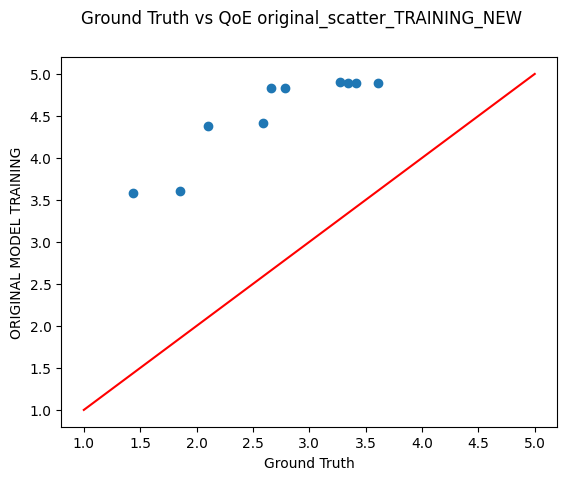

ORIGINAL MODEL TRAINING RMSE: 1.9938480520465247
Spearman Correlation
              Ground truth    P.1203
Ground truth      1.000000  0.910877
P.1203            0.910877  1.000000


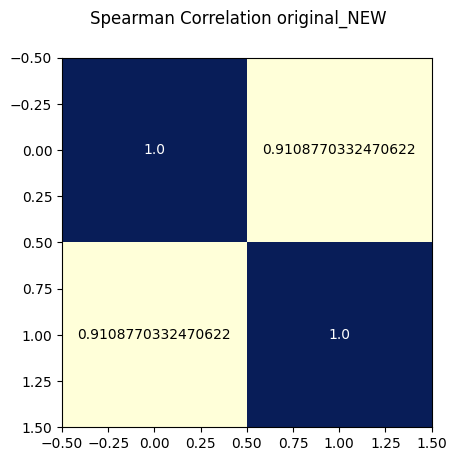

Pearson Correlation
              Ground truth    P.1203
Ground truth      1.000000  0.904375
P.1203            0.904375  1.000000


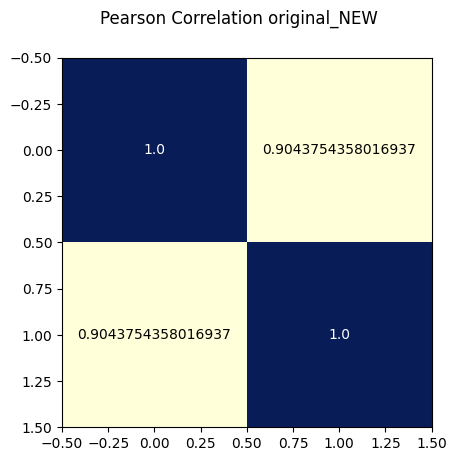

In [19]:
# Get the graphs and all the metrics for the original model on the validation dataset
process_p1203_and_groundtruth(
    p1203_df=p1203_df,
    ground_truth_df=ground_truth_df,
    filename_prefix="original",
    dataset_type=DatasetType.TRAINING,
    yaxis_label="ORIGINAL MODEL",
    results_filename="original",
)

--p1203_qoe_list--
[3.6093800843351866, 4.42174532858415, 4.837058584633231, 4.895940183337771, 4.895940183337771, 3.5929991359272795, 4.392942880641727, 4.837058584633231, 4.897756903569542, 4.895940183337771]
--ground_truth_sliced_mean VALIDATION--
           object start_qual end_qual   dist      rate
0     FlowerDance        r01      r01  200cm  1.731707
1     FlowerDance        r02      r02  200cm  2.390244
2     FlowerDance        r03      r03  200cm  2.902439
3     FlowerDance        r04      r04  200cm  3.365854
4     FlowerDance        r05      r05  200cm  3.804878
5  ReadyForWinter        r01      r01  200cm  1.658537
6  ReadyForWinter        r02      r02  200cm  2.073171
7  ReadyForWinter        r03      r03  200cm  2.731707
8  ReadyForWinter        r04      r04  200cm  3.390244
9  ReadyForWinter        r05      r05  200cm  3.658537
--qoe_ground_truth_sliced VALIDATION--
[1.7317073170731707, 2.3902439024390243, 2.902439024390244, 3.3658536585365852, 3.8048780487804876, 1.658

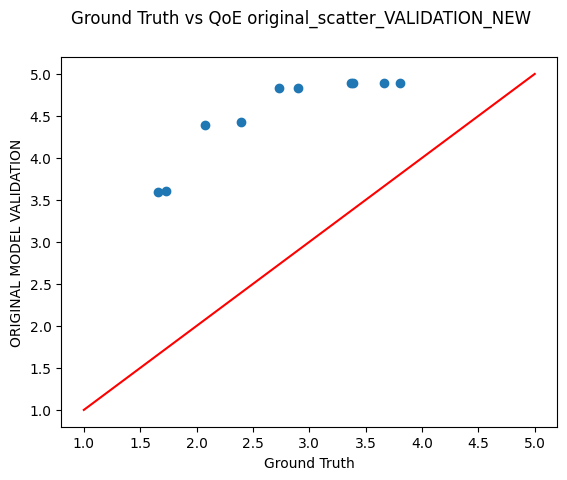

ORIGINAL MODEL VALIDATION RMSE: 1.9224791836933743
Spearman Correlation
              Ground truth    P.1203
Ground truth      1.000000  0.935495
P.1203            0.935495  1.000000


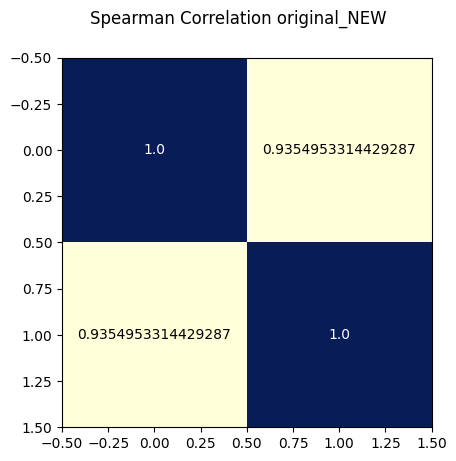

Pearson Correlation
              Ground truth    P.1203
Ground truth      1.000000  0.891688
P.1203            0.891688  1.000000


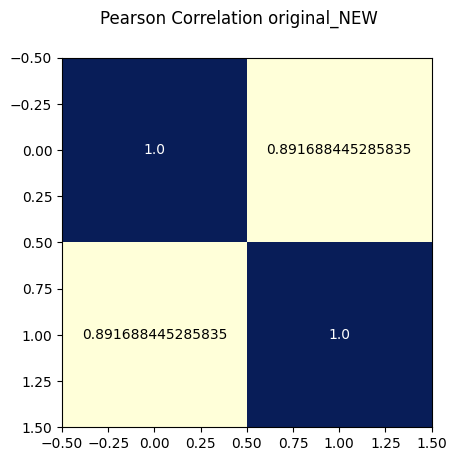

In [20]:
# Get the graphs and all the metrics for the original model on the training dataset
process_p1203_and_groundtruth(
    p1203_df=p1203_df,
    ground_truth_df=ground_truth_df,
    filename_prefix="original",
    dataset_type=DatasetType.VALIDATION,
    yaxis_label="ORIGINAL MODEL",
    results_filename="original",
)

In [21]:
# ground_truth_df contains all the ground truth data from the users
# ground_truth_training_df contains the training ground truth data

# # only keep the useful columns
# ground_truth_df = ground_truth_df[['object', 'start_qual', 'end_qual', 'dist', 'rate']]
# ground_truth_df['dist'] = ground_truth_df['dist'].apply(lambda x: get_dist_string(x))

configurations = ground_truth_df.groupby(groupby_columns, as_index=False)

# for each configuration, filter outliers
vpcc_filtered_df = None

# for each data frame in the configurations, filter the outliers
for _, frame in configurations:
    vpcc_filtered_df = pd.concat(
        [vpcc_filtered_df, boxplot_outlier_filter(frame)], axis=0
    )

# reset the index of the filtered data frame
vpcc_filtered_df = vpcc_filtered_df.reset_index(drop=True)

print("--vpcc_filtered_df--")
print(vpcc_filtered_df)  # THIS ONE IS THE FILTERED DATA WITH EVERYTHING

--vpcc_filtered_df--
        object start_qual end_qual   dist  rate
0     BlueSpin        r01      r01  200cm   1.0
1     BlueSpin        r01      r01  200cm   2.0
2     BlueSpin        r01      r01  200cm   2.0
3     BlueSpin        r01      r01  200cm   1.0
4     BlueSpin        r01      r01  200cm   2.0
...        ...        ...      ...    ...   ...
1878   Soldier         r5       r5  500cm   4.0
1879   Soldier         r5       r5  500cm   4.0
1880   Soldier         r5       r5  500cm   3.5
1881   Soldier         r5       r5  500cm   4.0
1882   Soldier         r5       r5  500cm   3.0

[1883 rows x 5 columns]


In [22]:
# set the ground truth training dataframe to the filtered data frame for the training objects
ground_truth_training_filtered_df = vpcc_filtered_df.loc[
    vpcc_filtered_df["object"].isin(training_object_names)
]

print("--ground_truth_training_filtered_df--")
print(ground_truth_training_filtered_df)

--ground_truth_training_filtered_df--
          object start_qual end_qual   dist  rate
0       BlueSpin        r01      r01  200cm   1.0
1       BlueSpin        r01      r01  200cm   2.0
2       BlueSpin        r01      r01  200cm   2.0
3       BlueSpin        r01      r01  200cm   1.0
4       BlueSpin        r01      r01  200cm   2.0
..           ...        ...      ...    ...   ...
383  CasualSquat        r05      r05  200cm   3.0
384  CasualSquat        r05      r05  200cm   2.0
385  CasualSquat        r05      r05  200cm   3.0
386  CasualSquat        r05      r05  200cm   4.0
387  CasualSquat        r05      r05  200cm   5.0

[388 rows x 5 columns]


In [23]:
# group the filtered training dataframe
ground_truth_training_grouped_df = ground_truth_training_filtered_df.groupby(
    groupby_columns, as_index=False
).aggregate(lambda x: tuple(x))

print("--ground_truth_training_grouped_df--")
print(ground_truth_training_grouped_df)

--ground_truth_training_grouped_df--
        object start_qual end_qual   dist  \
0     BlueSpin        r01      r01  200cm   
1     BlueSpin        r02      r02  200cm   
2     BlueSpin        r03      r03  200cm   
3     BlueSpin        r04      r04  200cm   
4     BlueSpin        r05      r05  200cm   
5  CasualSquat        r01      r01  200cm   
6  CasualSquat        r02      r02  200cm   
7  CasualSquat        r03      r03  200cm   
8  CasualSquat        r04      r04  200cm   
9  CasualSquat        r05      r05  200cm   

                                                rate  
0  (1.0, 2.0, 2.0, 1.0, 2.0, 3.0, 1.0, 1.0, 1.0, ...  
1  (2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...  
2  (2.0, 3.0, 2.0, 2.0, 3.0, 3.0, 2.0, 4.0, 2.0, ...  
3  (3.0, 4.0, 2.0, 2.0, 5.0, 3.0, 4.0, 5.0, 3.0, ...  
4  (3.0, 4.0, 2.0, 3.0, 4.0, 4.0, 4.0, 5.0, 3.0, ...  
5  (1.0, 2.0, 2.0, 2.0, 3.0, 2.0, 1.0, 2.0, 1.0, ...  
6  (2.0, 3.0, 1.0, 2.0, 3.0, 2.0, 2.0, 3.0, 2.0, ...  
7  (2.0, 3.0, 2.0, 3.0, 4.0

In [24]:
# do_all_optimization_methods(
#     current_optimization_method, ground_truth_training_grouped_df
# )

# Make the graph with the points on the linear line

In [25]:
# Original Model coeffs are here below

# First fine-tuned model from MHV paper coeffs 
# {'a1': 5, 'a2': -1.0, 'a3': 130, 'a4': 4.0}

In [26]:
# Default P1203 coefficients
COEFFS = {
    "u1": 72.61,
    "u2": 0.32,
    "t1": 30.98,
    "t2": 1.29,
    "t3": 64.65,
    "q1": 4.66,
    "q2": -0.07,
    "q3": 4.06,
    "mode0": {
        "a1": 11.9983519,
        "a2": -2.99991847,
        "a3": 41.2475074001,
        "a4": 0.13183165961,
    },
    "mode1": {
        "a1": 5.00011566,
        "a2": -1.19630824,
        "a3": 41.3585049,
        "a4": 0,
        "c0": -0.91562479,
        "c1": 0,
        "c2": -3.28579526,
        "c3": 20.4098663,
    },
    "htv_1": -0.60293,
    "htv_2": 2.12382,
    "htv_3": -0.36936,
    "htv_4": 0.03409,
}

In [27]:
def plot_scatter(ground_truth_df, p1203_results_list, labels_list, colors_list, dataset_string, model_string):

    # get the ground truth results averaged
    ground_truth_grouped = ground_truth_df.groupby(
        groupby_columns, as_index=False
    )

    ground_truth_points = list(ground_truth_grouped.mean()['rate'])

    plt.figure(figsize=(6, 4))
    for p1203_results, curr_label, curr_color in zip(p1203_results_list, labels_list, colors_list):
        # make a DF of the p1203 results so we can average them
        p1203_base_results_df = pd.DataFrame.from_dict(p1203_results)

        # Group the data by object name, start quality, and end quality
        p1203_df_grouped = p1203_base_results_df.groupby(groupby_columns, as_index=False)

        p1203_points = list(p1203_df_grouped.mean()["p1203_qoe"])

        
        plt.scatter(ground_truth_points, p1203_points, color=curr_color, label=curr_label)
        
    # Add y=x line to the plot
    plt.plot([1, 5], [1, 5], color = 'tab:brown')
    plt.axis([1, 5, 1, 5])

    # Label the axes
    plt.xlabel('Perceived MOS', fontsize=15)
    plt.ylabel('Predicted MOS', fontsize=15)

    # Add a legend
    if  len(labels_list) > 1:
        plt.legend(fontsize=13)   

    plt.tight_layout()
    plt.savefig('./figures/ITUP1203_' + dataset_string + '_' + model_string + ".pdf")  
    plt.show()

In [28]:
# # First we do it for both the datasets
# # making sure both bools are true above
# if old_tests != True or new_tests != True:
#     raise Exception("DATASET BOOLS NOT SET CORRECTLY!")

# # get the p.1203 results from the basic model
# p1203_base_results_both = calculate_p1203_for_everything(input_json)

# # SHGO Coeffs
# #[ 1.59453895 -0.20215047 26.40318509  2.12300797]
# COEFFS["mode0"]["a1"] = 1.59453895
# COEFFS["mode0"]["a2"] = -0.20215047
# COEFFS["mode0"]["a3"] = 26.40318509
# COEFFS["mode0"]["a4"] = 2.12300797

# p1203_shgo_results_both = calculate_p1203_for_everything(input_json, current_coeffs=COEFFS)

# # dual annealing
# #[ 2.45609984 -0.35897827 75.9109584   0.24476753]
# COEFFS["mode0"]["a1"] = 2.45609984
# COEFFS["mode0"]["a2"] = -0.35897827
# COEFFS["mode0"]["a3"] = 75.9109584
# COEFFS["mode0"]["a4"] = 0.24476753

# p1203_dualannealing_results_both = calculate_p1203_for_everything(input_json, current_coeffs=COEFFS)

In [29]:
# # Graph: MOS from dataset vs non-fine tuned on both datasets
# plot_scatter(ground_truth_df, [p1203_base_results_both], ['Base Model'], ['tab:blue'], 'bothdatasets', 'basemodel')

# p1203_results_list = [p1203_base_results_both, p1203_shgo_results_both, p1203_dualannealing_results_both]
# labels_list = ['Base Model', 'SHGO', 'Dual Annealing']
# colors_list = ['tab:blue', 'tab:orange', 'tab:green']

# # Graph: MOS from dataset vs fine-tuned SHGO and dual annealing on both datasets
# plot_scatter(ground_truth_df, p1203_results_list, labels_list, colors_list, 'bothdatasets', 'shgo_dualannealing')

In [ ]:
# Fine-tuned on ComPEQ-MR
# making sure only the second test bool is ticked above
if old_tests != False or new_tests != True:
    raise Exception("DATASET BOOLS NOT SET CORRECTLY!")

# get the p.1203 results from the basic model
p1203_base_results_compeq = calculate_p1203_for_everything(input_json)

# SHGO Coefficients
# [ 2.34966312 -0.40116217 25.83819051  0.04571008]
COEFFS["mode0"]["a1"] = 2.34966312
COEFFS["mode0"]["a2"] = -0.40116217
COEFFS["mode0"]["a3"] = 25.83819051
COEFFS["mode0"]["a4"] = 0.04571008


p1203_shgo_results_compeq = calculate_p1203_for_everything(input_json, current_coeffs=COEFFS)


# Dual Annealing
# [11.74427914 -2.40268249 77.42511117  4.99970309]
COEFFS["mode0"]["a1"] = 11.74427914
COEFFS["mode0"]["a2"] = -2.40268249
COEFFS["mode0"]["a3"] = 77.42511117
COEFFS["mode0"]["a4"] = 4.99970309

p1203_dualannealing_results_compeq = calculate_p1203_for_everything(input_json, current_coeffs=COEFFS)

# Brute Force
# [ 1.73684211 -0.26315789 12.63157895  2.89473684]
COEFFS["mode0"]["a1"] = 1.73684211
COEFFS["mode0"]["a2"] = -0.26315789
COEFFS["mode0"]["a3"] = 12.63157895
COEFFS["mode0"]["a4"] = 2.89473684

p1203_bruteforce_results_compeq = calculate_p1203_for_everything(input_json, current_coeffs=COEFFS)


In [35]:
# filter the ground truth
ground_truth_sliced = ground_truth_df.loc[
            ground_truth_df["object"].isin(training_object_names + validation_object_names)
        ]

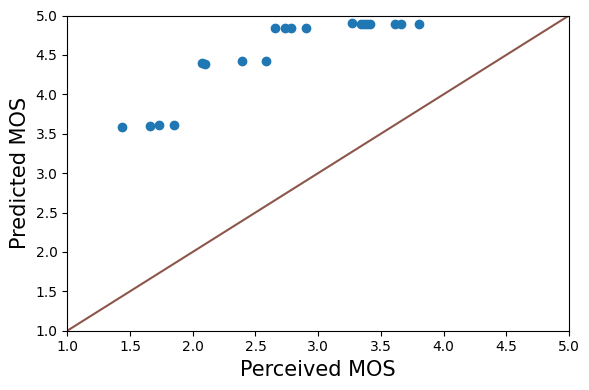

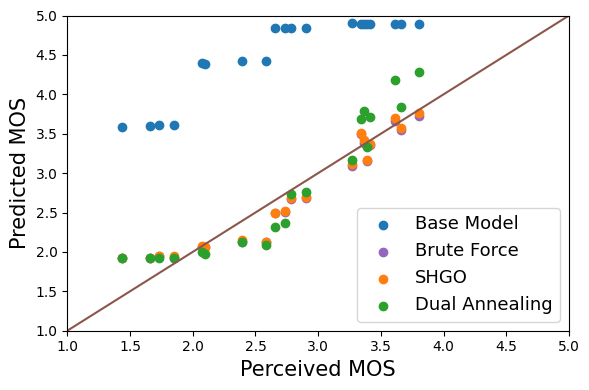

In [40]:
# Graph: MOS from dataset vs non-fine tuned model on ComPEQ-MR dataset
plot_scatter(ground_truth_sliced, [p1203_base_results_compeq], ['Base Model'], ['tab:blue'], 'compeq', 'basemodel')

p1203_results_list = [p1203_base_results_compeq, p1203_bruteforce_results_compeq, p1203_shgo_results_compeq, p1203_dualannealing_results_compeq]
labels_list = ['Base Model', 'Brute Force', 'SHGO', 'Dual Annealing']
colors_list = ['tab:blue', 'tab:purple', 'tab:orange', 'tab:green']

# Graph: MOS from dataset vs fine-tuned predicted QoE Blue (SHGO), Green (Dual Annealing) and Red (Brute) on ComPEQ-MR dataset
plot_scatter(ground_truth_sliced, p1203_results_list, labels_list, colors_list, 'compeq', 'shgo_dualannealing_bruteforce')

In [ ]:


# get the p.1203 results from the older fine-tuned model


# get the p.1203 results of the newer fine-tuned models


# make the graphs

# 1. MOS from dataset vs non-fine tuned model on ComPEQ-MR dataset
# 2. MOS from dataset vs fine-tuned predicted QoE Blue (SHGO), Green (Dual Annealing) and Red (Brute) on ComPEQ-MR dataset



